# Lidar Processing Workflow
**Cara Piske, Graduate Program of Hydrologic Sciences, 2022; Advisor: Dr. Adrian Harpold**<br>
This code processes raw lidar point clouds in order to calculate snow depth using PDAL. <br>
Lidar data were provided by the Airborne Snow Observatory (ASO), the National Center for Airborne Laser Mapping (NCALM), and Watershed Sciences Inc. (WSI). <br>

The goal of this project is to process snow depth to the one-meter spatial scale while maintaining conservative under-canopy estimates. Therefore, little interpolation occurs under-canopy. We follow these protocols in order to obtain a 1-m rasterized product (as opposed to the 3-m rasterized product provided by ASO on the NSIDC data portal). NCALM and WSI flights were obtained through OpenTopography.

Start by importing necessary files

In [1]:
# import necessary files
import numpy as np 
import matplotlib.pyplot as plt
import json # where we will save the json files to run a pipeline
import os # for file management
import subprocess # allows us to run command line commands
import pdal # lidar processing package
import rasterio
import pyproj
from osgeo import gdal

import time
# packages to copy files
from pathlib import Path
import shutil
import glob
# packages to extract wkt from polygon
import shapefile
import pygeoif
# for parallel processing
import concurrent.futures
from multiprocessing import Pool
import csv

import re
import seaborn as sns
import scipy
#import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import kde
from scipy.stats import gaussian_kde
# from sklearn import linear_model
# from sklearn.metrics import mean_squared_error, r2_score
# See lidar_functions.py
import lidar_functions


Note that many functions are dependent on specific directory structures. See README

In [2]:
json_base_path = 'piske_processing/PDAL_workflow/JSON/' # set so that we can redefine json across operating systems

Applied

In [3]:
# Set current working directory
path = '/Volumes/Piske_lidar'
os.chdir(path)
os.getcwd() # print to ensure we're in the right directory

'/Volumes/Piske_lidar'

In [4]:
# All json paths
# define all json files
filterMergeRasterize_json = json_base_path + 'filterMergeRasterize.json'
DEM_json = json_base_path+'DEM_from_las.json' 
HAG_json = json_base_path + 'HAG_dem.json'
clip_json = json_base_path +'clip_to_polygon.json'
extract_las_atPoint = json_base_path +'extract_las_atPoint.json'
extract_las_atPolygon = json_base_path +'extract_las_atPolygon.json'
correct_merge_rasterize_json = json_base_path + 'correct_merge_rasterize.json'
las_to_laz_json = json_base_path + 'las_to_laz.json'

# Pre-Processing

In [5]:
las_to_laz_json = json_base_path + 'las_to_laz.json'

In [23]:
# filter out the ground points of the tiles
reader_las = {"type":"readers.las"}
# write merged las to raster
writers_las= {"type": "writers.las",
             'a_srs':"PROJCS[\"NAD83(2011) / UTM zone 10N\",GEOGCS[\"NAD83(2011)\",DATUM[\"NAD83_National_Spatial_Reference_System_2011\",SPHEROID[\"GRS 1980\",6378137,298.257222101,AUTHORITY[\"EPSG\",\"7019\"]],AUTHORITY[\"EPSG\",\"1116\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"6318\"]],PROJECTION[\"Transverse_Mercator\"],PARAMETER[\"latitude_of_origin\",0],PARAMETER[\"central_meridian\",-123],PARAMETER[\"scale_factor\",0.9996],PARAMETER[\"false_easting\",500000],PARAMETER[\"false_northing\",0],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]],AXIS[\"Easting\",EAST],AXIS[\"Northing\",NORTH],AUTHORITY[\"EPSG\",\"6339\"]]"}
# Append each stage to a list prior to saving to json 
pipeline_list = [reader_las, writers_las]
pipeline_dict = {'pipeline' : pipeline_list}
# save to json
with open(las_to_laz_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [25]:
# # one folder
# tic = time.perf_counter()
# lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/las/'
# output_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/laz/'
# if __name__ == '__main__':
#     with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
#         onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
#         full_path = [os.path.join(lidar_folder, s) for s in onlyfiles]
#         # change depending on directory formats
#         output_path = [output_folder + s[:-3] + 'laz' for s in onlyfiles]
#         executor.map(lidar_functions.las_to_laz, full_path, output_path) 
# toc = time.perf_counter()

## Info

In [10]:
# define input file
input_lid = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/NCALM_SCB_20220321_730000_4368000.laz'
pdal_info_cmd = ['pdal','info',input_lid] # general info
pdal_metadata_cmd = ['pdal','info',input_lid,'--metadata'] # full file metadata, including details crs
#subprocess.run(pdal_metadata_cmd)

In [8]:
pdal_info_results = subprocess.run(pdal_metadata_cmd, stdout = subprocess.PIPE) # stout (standard out), PIPE indicates that a new pipe to the child should be created
pdal_info_dict = json.loads(pdal_info_results.stdout.decode()) # create dict with metadata info
#pdal_info_dict # print results

In [70]:
# pdal_info_dict

Check extents (in order to create bounds for rasterization below)

In [10]:
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/las/'
# lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/NAD83_NAD83_epoch2010/'
onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
full_paths = [lidar_folder +f for f in onlyfiles]

In [ ]:
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/las/'
output_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/laz/'
onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
full_paths = [lidar_folder +f for f in onlyfiles]
for files in onlyfiles:
    input_lidar = lidar_folder + files
    output_lidar = output_folder + files[:-3]+ 'laz'
    pdal_cmd = ['pdal','translate',input_lidar, output_lidar]
    subprocess.run(pdal_cmd)

(pdal translate readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(pdal translate readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(pdal translate readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(pdal translate readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(pdal translate readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(pdal translate readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(pdal translate readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(pdal translate readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(pdal translate readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(pdal translate readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(pdal translate readers.las Error) Global encoding WKT flag not set fo

In [31]:
# NCALM_snowOff_ext = lidar_functions.check_flight_extent(full_paths)
# NCALM_snowOn_ext = lidar_functions.check_flight_extent(full_paths)

In [32]:
print(NCALM_snowOn_ext)
print(NCALM_snowOff_ext)

[730260.55, 739529.25, 4364442.12, 4372464.33, 9268.699999999953, 8022.209999999963]
[728878.85, 741181.8, 4363699.94, 4373425.02, 12302.95000000007, 9725.079999999143]


05/18/2016 has the most limited extent, so we'll use those bounds for rasterization.

## Retile

In [ ]:
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/NAD83_NAD83_epoch2010/'
retile_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/retile_uo/'
onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
for files in onlyfiles:
    full_path = os.path.join(lidar_folder, files)
    output_path = retile_folder+'#' + files
    retile_command = ['pdal', 'tile', full_path, output_path, '--length=1000','--buffer=50']
    subprocess.run(retile_command)

## Rename

In [ ]:
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/laz/'
tic = time.perf_counter()
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
        onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
        full_path = [os.path.join(lidar_folder, s) for s in onlyfiles]
        executor.map(lidar_functions.rename_llx_lly, full_path) 
toc = time.perf_counter()

In [34]:
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/las/'
tic = time.perf_counter()
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
        onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
        full_path = [os.path.join(lidar_folder, s) for s in onlyfiles]
        executor.map(lidar_functions.add_str_to_filename, full_path) 
toc = time.perf_counter()

## Save Tile Boundaries

In [35]:
# one folder
tic = time.perf_counter()
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/las/'
output_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/tindex/original/'
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
        onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
        full_path = [os.path.join(lidar_folder, s) for s in onlyfiles]
        # change depending on directory formats
        #output_path = [os.path.join(os.path.basename(lidar_folder),'tindex/tiles/' + s[:-3] + 'sqlite') for s in onlyfiles]
        output_path = [output_folder + s[:-3] + 'sqlite' for s in onlyfiles]
        executor.map(lidar_functions.create_tindex, full_path, output_path) #running 10 times
toc = time.perf_counter()

(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point format 6 - 10.
(readers.las Error) Global encoding WKT flag not set for point f

## Copy Files

In [ ]:
tic = time.perf_counter()
lidar_folder = 'MRB/Merced_lidar/ASO/ASO_MRB_20210429/laz/'
output_path = 'MRB/Merced_lidar/ASO/ASO_MRB_20210429/ICB_tiles/'
onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
full_paths = [os.path.join(lidar_folder, s) for s in onlyfiles] 
output_paths = np.repeat(output_path, len(full_paths))
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
        executor.map(lidar_functions.copy_lid_by_ext_ICB, full_paths, output_paths)
toc = time.perf_counter()

# Create DEM

In [129]:
DEM_json = json_base_path+'DEM_from_las.json' # define path to json files

In [119]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/NAD83_NAD83_epoch2010/'
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/NCALM_2014_BE_scb.tif'
onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
input_list = [input_path + s for s in onlyfiles]

In [120]:
filename_dict = {}
tags = ['']*len(input_list)
filenames = ['']*len(input_list)
for i in range(len(input_list)):
    filename_dict['filename_'+str(i)] = {'filename':input_list[i], 'tag':'A_'+str(i)}
    tags[i] = 'A_'+str(i)
    filenames[i] = filename_dict[list(filename_dict)[i]]

In [ ]:
writers_bounds = '(['+ str(ASO_SCB_20160518_ext[0])+','+ str(ASO_SCB_20160518_ext[1])+'],['+str(ASO_SCB_20160518_ext[2])+','+str(ASO_SCB_20160518_ext[3])+'])'

In [121]:
# filter out the ground points of the tiles
filter_range = {"type":"filters.range",
                "limits":"Classification[2:2]"}
# merge all las files or stages
filter_merge = {"type":"filters.merge",
               "tag": "merged",
               "inputs": tags}
# write merged las to raster
writers_gdal= {"type": "writers.gdal",
               'output_type': 'mean', 
              'resolution': '1.0',
               'bounds': writers_bounds,
              'radius': '0.7',
               'window_size':3,# we want more of a wall-to-wall product here so we use a secondary algorithm to increase calculation distance
               'filename': output_tif}
# Append each stage to a list prior to saving to json 
pipeline_list = filenames.copy()
pipeline_list.append(filter_merge)
pipeline_list.append(filter_range)
pipeline_list.append(writers_gdal)
pipeline_dict = {'pipeline' : pipeline_list}
# save to json
with open(DEM_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [122]:
tic = time.perf_counter()
pdal_cmd = ['pdal','pipeline', DEM_json]
subprocess.run(pdal_cmd)
toc = time.perf_counter()

In [124]:
(toc-tic)/60

18.200616948333725

## Heigh Above Ground

In [ ]:
# define json path 
HAG_json = json_base_path + 'HAG_dem.json'
# convert all z values to the height above ground 
target_dem = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/NCALM_2014_BE.tif'
filter_hag = {"type":"filters.hag_dem",
              "raster":target_dem, # full file path of target DEM (.tif)
              "zero_ground":"false"} # Do not assign 0 to ground classified points
filter_ferry = {"type":"filters.ferry",
                "dimensions":"HeightAboveGround=>Z"} # replace all Z dimensions with HAG instead of elevation
filter_range = {"type":"filters.range",
                "limits":"Z[-0.2:70]"} # apply a noise filter
pipeline_list = [filter_hag, filter_ferry,filter_range]
pipeline_dict = {'pipeline' : pipeline_list}
with open(HAG_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [ ]:
# parallel processing
# time = 1.1 min
tic = time.perf_counter()
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/NAD83_NAD83_epoch2010/'
output_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/HAG/'
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
        onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
        full_path = [input_path + s for s in onlyfiles]
        output_path_full = [output_path  + s for s in onlyfiles]
        executor.map(lidar_functions.HAG_dem, full_path, output_path_full)

In [154]:
# parallel processing
# time = 1.1 min
tic = time.perf_counter()
input_path = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/NAD83_NAD83_epoch2010/'
output_path = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/HAG/'
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
        onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
        full_path = [input_path + s for s in onlyfiles]
        output_path_full = [output_path  + s for s in onlyfiles]
        executor.map(lidar_functions.HAG_dem, full_path, output_path_full)

In [88]:
# parallel processing
# time = 1.1 min
tic = time.perf_counter()
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/NAD83_NAD83_epoch2010/'
output_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/HAG/'
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
        onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
        full_path = [input_path + s for s in onlyfiles]
        output_path_full = [output_path  + s for s in onlyfiles]
        executor.map(lidar_functions.HAG_dem, full_path, output_path_full)

RASTERIZE TEST

In [397]:
# parallel processing
# time = 1.1 min
tic = time.perf_counter()
input_path = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/HAG/'
output_path = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/rasterize_test_count/'
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
        onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
        full_path = [input_path + s for s in onlyfiles]
        output_path_full = [output_path  + s for s in onlyfiles]
        executor.map(lidar_functions.rasterize_count, full_path, output_path_full)

# Vertical Bias Correction

## Move Files

In [159]:
# defining source and destination
# paths
src = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/HAG/*.la*'
trg = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/hwy89_vertical_bias/target_lid'
file_paths = glob.glob(src)

for files in file_paths:
    filename = os.path.basename(files)
    if int(files[-18:-12]) > 737000 and int(files[-11:-4]) > 4370000:
    # copying the files to the
    # destination directory
        shutil.copy2(files, trg)

### Merge

In [165]:
input_path = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/hwy89_vertical_bias/target_lid/*.la*' # define path of input files
input_fname = glob.glob(input_path) # save to list
output_fname = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/hwy89_vertical_bias/target_lid/ASO_SCB_20160326_hwy89_merge.'+input_fname[0][-3:]# set output filename
pdal_merge_command = input_fname
pdal_merge_command.insert(len(pdal_merge_command),output_fname) # insert output file to list
#pdal_merge_command.insert(0,'-f')
pdal_merge_command.insert(0,'merge')
pdal_merge_command.insert(0,'pdal')
subprocess.run(pdal_merge_command)

### Clip

#### ASO 2016
The 2016 data uses points overlapping a hwy89 polygon for vertical bias correction because it should have no snow. 

In [15]:
# name JSON file
clip_json = json_base_path +'clip_to_geometries.json'

In [24]:
path_to_shapefile = 'SCB/supporting_files/bounding_box/hwy89_poly.shp'

In [25]:
# extract wkt from hwy 89 polygon
hwy89 = shapefile.Reader(path_to_shapefile)
geom=[]
for s in hwy89.shapes():
    geom.append(pygeoif.geometry.as_shape(s)) 
poly_base = pygeoif.MultiPolygon(geom)
target_poly = poly_base.wkt

In [26]:
def extract_las_atPolygon(filenames, tags, target_poly, output_txt):
    # merge all las files or stages
    filter_merge = {"type":"filters.merge",
                    "tag": "merged",
                    "inputs": tags}
    # crop
    filter_crop = {'type':'filters.crop',
                   'polygon':target_poly,
                   'distance':1,
                   'inputs':'merged',
                   'tag': 'cropped'}
    # write merged las to raster
    writers_gdal = {"type":"writers.text",
                    "format":"csv",
                    "order":"Z",
                    'keep_unspecified':False,
                    'filename':output_txt}
    # Append each stage to a list prior to saving to json 
    pipeline_list = filenames.copy()
    pipeline_list.append(filter_merge)
    pipeline_list.append(filter_crop)
    pipeline_list.append(writers_gdal)

    pipeline_dict = {'pipeline' : pipeline_list}
    # save to json
    with open(extract_las_atPolygon_json, 'w') as out:
        json.dump(pipeline_dict, out, indent=4)
    pdal_cmd = ['pdal','pipeline', extract_las_atPolygon_json]
    subprocess.run(pdal_cmd)

In [19]:
input_las = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/hwy89_vertical_bias/target_lid/ASO_SCB_20160518_hwy89_merge.las'
output_txt = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/hwy89_vertical_bias/clipped/ASO_SCB_20160518_hwy89_clip.txt'

In [119]:
pdal_commands = ['pdal', 'translate', input_las, output_txt, '--json', clip_json]
subprocess.run(pdal_commands)

#### NCALM 2008
The 2008 data uses snow-on field data extracted at points for vertical bias correction. <br>

In [41]:
# name JSON file
extract_las_atPoint_json = json_base_path +'extract_las_atPoint.json'

In [48]:
# Read in ground_truthed data
def csv_to_list(input_csv):
    src = open(input_csv)
    csvreader = csv.reader(src)
    header = next(csvreader)
    output_list = []
    for row in csvreader:
        output_list.append(row)
    src.close()
    return(header, output_list)

In [304]:
def extract_las_atPoint(filenames, tags, target_point, output_txt,distance):
    # merge all las files or stages
    filter_merge = {"type":"filters.merge",
                    "tag": "merged",
                    "inputs": tags}
    # crop
    filter_crop = {'type':'filters.crop',
                   'point':target_point,
                   'distance':distance,
                   'inputs':'merged',
                   'tag': 'cropped'}
    # crop
    filter_range = {'type':'filters.range',
                   'limits':'Classification[2:2]',
                   'inputs':'cropped',
                   'tag': 'range'}
    
    # write merged las to raster
    writers_gdal = {"type":"writers.text",
                    "format":"csv",
                    "order":"Z",
                    "write_header":False,
                    'keep_unspecified':False,
                    'filename':output_txt}
    # Append each stage to a list prior to saving to json 
    pipeline_list = filenames.copy()
    pipeline_list.append(filter_merge)
    pipeline_list.append(filter_crop)
    pipeline_list.append(filter_range)
    pipeline_list.append(writers_gdal)

    pipeline_dict = {'pipeline' : pipeline_list}
    # save to json
    with open(extract_las_atPoint_json, 'w') as out:
        json.dump(pipeline_dict, out, indent=4)
    pdal_cmd = ['pdal','pipeline', extract_las_atPoint_json]
    subprocess.run(pdal_cmd)

In [63]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/HAG/'
output_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/vertical_bias_correction/'
filenames, tags = lidar_functions.create_command_template(input_path)

In [49]:
# extract data from field data
SNOTEL_src = "SCB/supporting_files/Harpold_data_paper/snowdepth_filtered.csv"
snotel_header, snotel_data = csv_to_list(SNOTEL_src)
hunt_src = 'SCB/supporting_files/Huntingon_2008_snow/Hungington_2008_snow.csv'
hunt_header, hunt_data = csv_to_list(hunt_src)

In [306]:
for i in range(len(hunt_data)):
    for j in range(1,6):
        output_txt = output_path+'huntington_'+str(i)+'_dist'+str(j)+'.csv'
        target_point = 'POINT('+hunt_data[i][7]+' '+hunt_data[i][8]+')'
        extract_las_atPoint(filenames, tags, target_point, output_txt,j)

In [307]:
# time = 4 min
for i in range(len(snotel_data)):
    for j in range(1,6):
        output_txt = output_path+'snotel_'+str(i)+'_dist'+str(j)+'.csv'
        target_point = 'POINT('+snotel_data[i][5]+' '+snotel_data[i][6]+')'
        extract_las_atPoint(filenames, tags, target_point, output_txt,j)

## Calculate Stats

Applied
Using 2014 NCALM Flight

In [44]:
ASO_20160326_hwy89_stats = lidar_functions.calculate_vertical_bias('SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/hwy89_vertical_bias/clipped/ASO_SCB_20160326_hwy89_clip.laz')
ASO_20160417_hwy89_stats = lidar_functions.calculate_vertical_bias('SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/hwy89_vertical_bias/clipped/ASO_SCB_20160417_hwy89_clip.laz')
ASO_20160518_hwy89_stats = lidar_functions.calculate_vertical_bias('SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/hwy89_vertical_bias/clipped/ASO_SCB_20160518_hwy89_clip.las')

In [45]:
NCALM_2014_hwy89_stats = lidar_functions.calculate_vertical_bias('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/hwy89_vertical_bias/clipped/NCALM_SCB_2014_hwy89_clip.las')

In [46]:
print(ASO_20160326_hwy89_stats)
print(ASO_20160417_hwy89_stats)
print(ASO_20160518_hwy89_stats)


['lowest_10th', 0.24, 'mean', 0.3113292433537832, 'median', 0.31]
['lowest_10th', 0.27, 'mean', 0.3502506714413608, 'median', 0.35]
['lowest_10th', 0.37, 'mean', 0.4511492281303602, 'median', 0.44]


**NCALM 2008**

In [238]:
# input_las_txt = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/SNOTEL_vertical_bias/clipped/snotel_541.csv'
input_las_txt = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/SNOTEL_vertical_bias/clipped/snotel_539.csv'

In [239]:
hag_arr = np.loadtxt(input_las_txt,skiprows=1)
lowest_10th_per = np.nanpercentile(hag_arr, 10)
mean_hag = np.nanmean(hag_arr)
median_hag = np.nanmedian(hag_arr)
stats_539 = ["lowest_10th",lowest_10th_per, "mean",mean_hag, "median", median_hag]

In [90]:
NCALM_2008_vbc_dict = {}
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/vertical_bias_correction/ground_pts/'
onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))] # make a list of all filenames in directory

In [93]:
NCALM_2008_vbc_dict = {}
all_files = glob.glob('SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/vertical_bias_correction/ground_pts/*')
for files in onlyfiles:
    txt_path = input_path + files
    txt_arr = np.loadtxt(txt_path)
    NCALM_2008_vbc_dict[files[:-4]] = txt_arr

In [94]:
NCALM_2008_error_dict = {}
keys_list = list(NCALM_2008_vbc_dict.keys())
for i in range(len(keys_list)):
    index = int(re.findall(r'\d+',  keys_list[i])[0])
    if keys_list[i][0:3]=='hun':
        NCALM_2008_error_dict[keys_list[i]] = float(hunt_data[index][4]) - NCALM_2008_vbc_dict[keys_list[i]]
    elif keys_list[i][0:3]=='sno':
        NCALM_2008_error_dict[keys_list[i]] = float(snotel_data[index][4])/100 - NCALM_2008_vbc_dict[keys_list[i]]
    else:
        print('error')

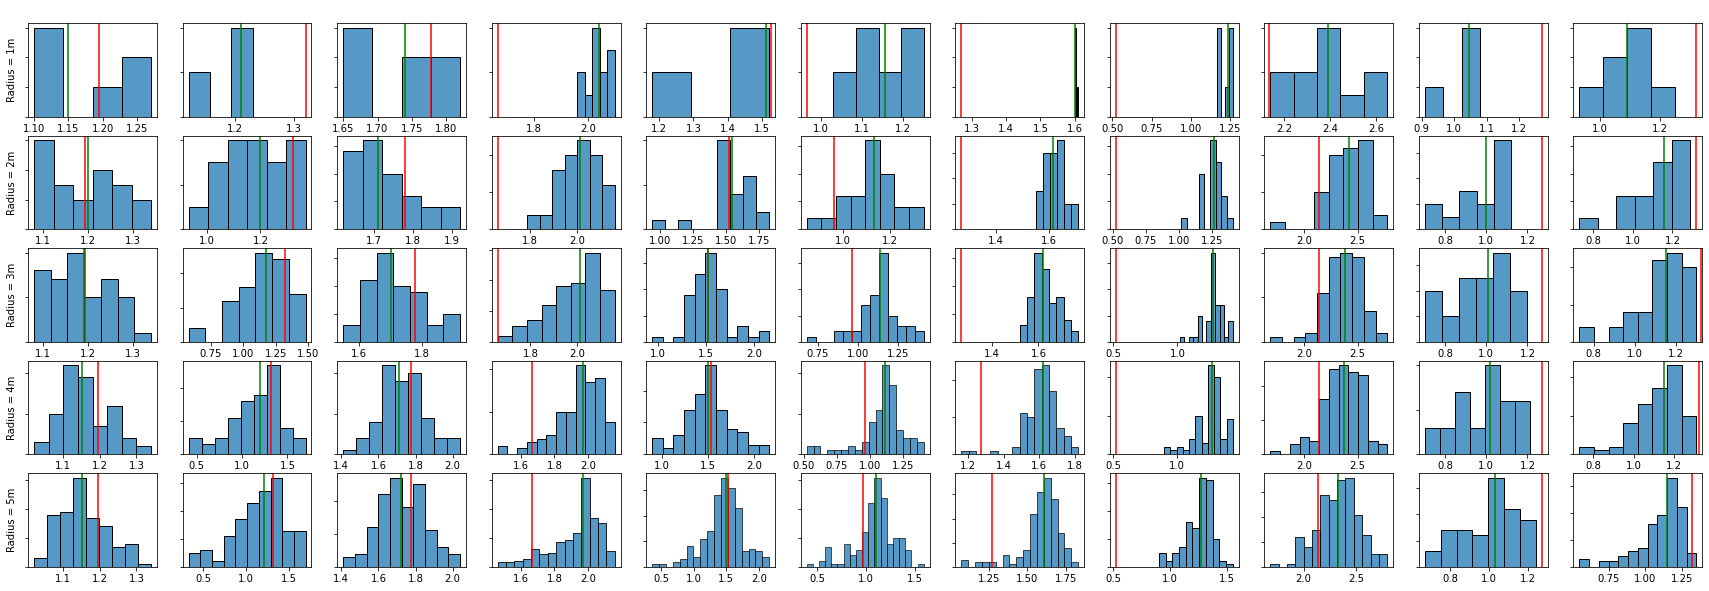

In [427]:
NCALM_2008_error_plot, axs = plt.subplots(5, 11, figsize =(30,10));
#NCALM_2008_error_plot.suptitle('NCALM 2008 Lidar Depth Distributions Around Ground Truth') # add title to entire figure

k = 0
for i in range(11):
    for j in range(5):
        keys_list = list(NCALM_2008_vbc_dict.keys())
        index = int(re.findall(r'\d+',  keys_list[k])[0])
        true_val = float(hunt_data[index][4])
        g = sns.histplot(ax = axs[j,i], data = NCALM_2008_vbc_dict[keys_list[k]])
        med = np.median(NCALM_2008_vbc_dict[keys_list[k]])
        g.axvline(true_val, color='red')
        g.axvline(med, color = 'green')
        y_lab = str(j+1)+'m'
        x_lab = "Point " +str(i)
        axs[j,i].set(yticklabels = [], title=' ',xlabel = '',ylabel ='')
        axs[0,0].set_ylabel('Radius = 1m'); axs[1,0].set_ylabel('Radius = 2m');axs[2,0].set_ylabel('Radius = 3m');axs[3,0].set_ylabel('Radius = 4m');axs[4,0].set_ylabel('Radius = 5m')
        k = k+1

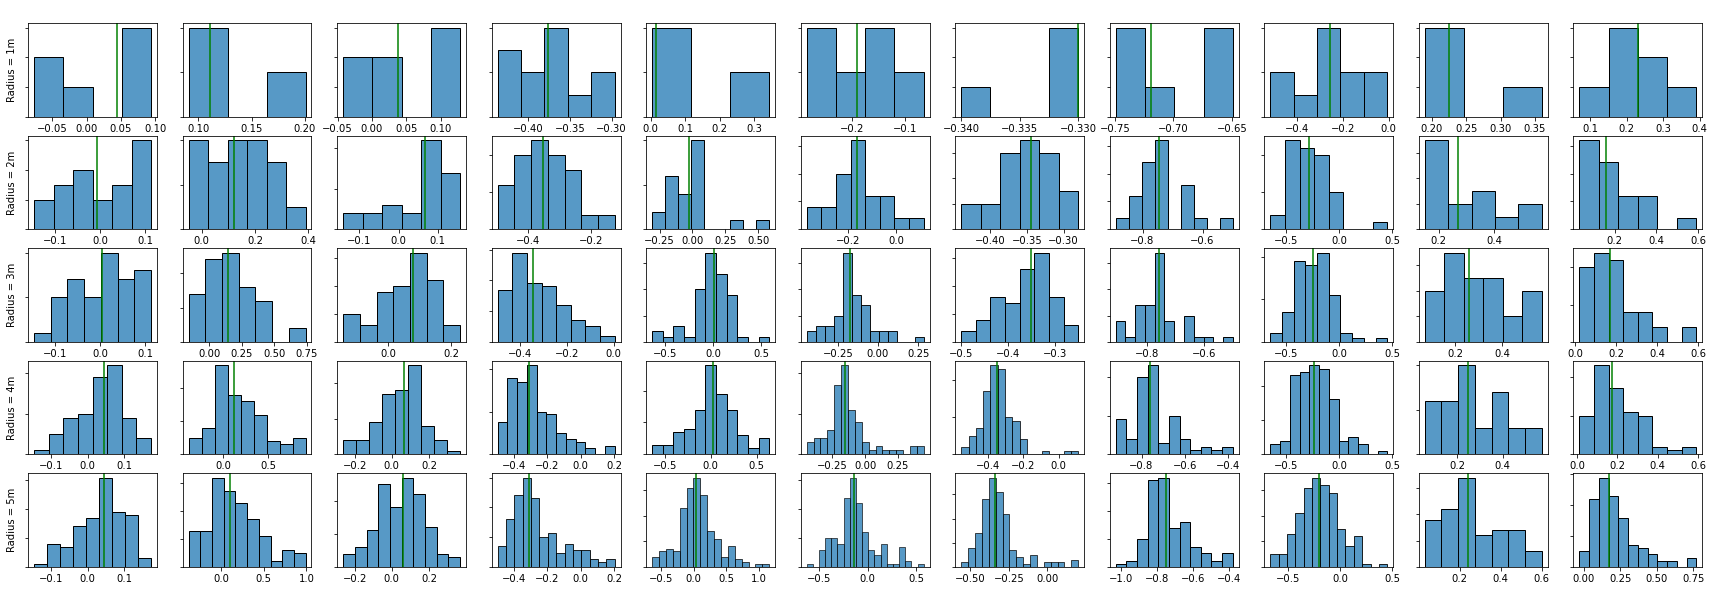

In [430]:
NCALM_2008_error_plot, axs = plt.subplots(5, 11, figsize =(30,10));
#NCALM_2008_error_plot.suptitle('NCALM 2008 Lidar Depth Distributions Around Ground Truth') # add title to entire figure

k = 0
for i in range(11):
    for j in range(5):
        keys_list = list(NCALM_2008_error_dict.keys())
        index = int(re.findall(r'\d+',  keys_list[k])[0])
        #true_val = float(hunt_data[index][4])
        g = sns.histplot(ax = axs[j,i], data = NCALM_2008_error_dict[keys_list[k]])
        med = np.median(NCALM_2008_error_dict[keys_list[k]])
        # g.axvline(true_val, color='red')
        g.axvline(med, color = 'green')
        y_lab = str(j+1)+'m'
        x_lab = "Point " +str(i)
        axs[j,i].set(yticklabels = [], title=' ',xlabel = '',ylabel ='')
        axs[0,0].set_ylabel('Radius = 1m'); axs[1,0].set_ylabel('Radius = 2m');axs[2,0].set_ylabel('Radius = 3m');axs[3,0].set_ylabel('Radius = 4m');axs[4,0].set_ylabel('Radius = 5m')
        k = k+1

In [96]:
def calculate_error(dist):
    error_med = []
    keys_list = list(NCALM_2008_error_dict.keys())
    for k in range(int(len(NCALM_2008_error_dict))):
        if int(re.findall(r'\d+',  keys_list[k])[1])==dist:
            error_med.extend(NCALM_2008_error_dict[keys_list[k]])
    return(error_med)

In [97]:
error_med_2 = calculate_error(2)
error_med_3 = calculate_error(3)
error_med_4 = calculate_error(4)
error_med_5 = calculate_error(5)

In [102]:
print("Radius = 2m, median error = ",np.median(error_med_2),'stdev = ',np.std(error_med_2))
print("Radius = 3m, median error = ",np.median(error_med_3),'stdev = ',np.std(error_med_3))
print("Radius = 4m, median error = ",np.median(error_med_4),'stdev = ',np.std(error_med_4))
print("Radius = 5m, median error = ",np.median(error_med_5),'stdev = ',np.std(error_med_5))

Radius = 2m, median error =  -0.07620000000000005 stdev =  0.3939059976952006
Radius = 3m, median error =  -0.04640000000000022 stdev =  0.38573160057604067
Radius = 4m, median error =  -0.03958333299999994 stdev =  0.37924952640387316
Radius = 5m, median error =  -0.029200000000000115 stdev =  0.3819159572093684


hold off on corrections for now

## Correct and Rasterize
In this case we know that the May flight has the most limited extent. One way to check for this would be to use a similar code to 

In [114]:
correct_merge_rasterize_json = json_base_path + 'correct_merge_rasterize_Zlim_5.json'

In [115]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/HAG/'
filenames, tags = lidar_functions.create_command_template(input_path)
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/corrected_tif/NCALM_SCB_20080210_vbc_5.tif'
target_assign = 'Z-0.03'#'Z-'+str(abs(ASO_20160518_hwy89_stats[1]))

Create the reader stages of the pipeline. Each file is read as an individual reader stage here, and we cheat here by copying the formatting of json files and creating a dictionary with the values as the correctly formatted inputs.

In [116]:
# [730235.96, 738826.45, 4364741.66, 4372273.16, 8590.48999999999, 7531.5]
writers_bounds = '(['+ str(ASO_SCB_20160518_ext[0])+','+ str(ASO_SCB_20160518_ext[1])+'],['+str(ASO_SCB_20160518_ext[2])+','+str(ASO_SCB_20160518_ext[3])+'])'

In [117]:
# merge all las files or stages
filter_merge = {"type":"filters.merge",
               "tag": "merged",
               "inputs": tags}
# filter out the ground points of the tiles
filter_assign = {'type': 'filters.assign',
                 'value':"Z="+target_assign,
                 'inputs':'merged',
                 'tag':'corrected'}
# filter out the ground points of the tiles
# filter_range = {'type': 'filters.range',
#                  'limits':"Z[0.15:5]",
#                  'inputs':'corrected',
#                  'tag':'ranged'}
filter_range = {'type': 'filters.range',
                 'limits':"Z[:5]",
                 'inputs':'corrected',
                 'tag':'ranged'}
# write merged las to raster
writers_gdal= {"type": "writers.gdal",
               'output_type': 'mean',
              'resolution': '1.0',
              'radius': '0.7',
               'bounds': writers_bounds,
               'inputs': 'ranged',
               'filename':output_tif}
# Append each stage to a list prior to saving to json 
pipeline_list = filenames.copy()
pipeline_list.append(filter_merge)
pipeline_list.append(filter_assign)
pipeline_list.append(filter_range)
pipeline_list.append(writers_gdal)

pipeline_dict = {'pipeline' : pipeline_list}
# save to json
with open(correct_merge_rasterize_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [118]:
# time = ~3 min
pdal_cmd = ['pdal','pipeline', correct_merge_rasterize_json]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/correct_merge_rasterize_Zlim_5.json'], returncode=0)

## Snow-Off Processing

### Vegetation Strata

**Combined Pipeline Method**
We'll use the same bounds as above

In [68]:
#filterMergeRasterize_json = json_base_path+'filterMergeRasterize.json'
# filterMergeRasterize_json = json_base_path+'filterMergeRasterize_neg0pt15_0pt15.json'
# filterMergeRasterize_json = json_base_path+'filterMergeRasterize_0pt15_2.json'
# filterMergeRasterize_json = json_base_path+'filterMergeRasterize_2.json'
filterMergeRasterize_json = json_base_path+'filterMergeRasterize_0pt15_0pt15.json'
# filterMergeRasterize_json = json_base_path+'filterMergeRasterize_2_nonground.json'


In [69]:
writers_bounds = '(['+ str(ASO_SCB_20160518_ext[0])+','+ str(ASO_SCB_20160518_ext[1])+'],['+str(ASO_SCB_20160518_ext[2])+','+str(ASO_SCB_20160518_ext[3])+'])'

In [70]:
# '([730235.96,738826.45],[4364741.66,4372273.16])'

In [71]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/HAG/'
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/veg_strata/veg_classes/vegStrata_0pt15_1pt5.tif'
filenames, tags = lidar_functions.create_command_template(input_path)

In [72]:
# merge all las files or stages
filter_merge = {"type":"filters.merge",
               "tag": "merged",
               "inputs": tags}
# filter out the ground points of the tiles
filter_range = {"type":"filters.range",
                "limits":"Z[0.15:1.5)",
               'inputs':'merged',
               'tag':'filtered'}
# write merged las to raster
writers_gdal= {"type": "writers.gdal",
               'output_type': 'count',
              'resolution': '1.0',
              'radius': '0.7',
               'bounds': writers_bounds,
               'inputs': 'filtered',
               'filename':output_tif}
# Append each stage to a list prior to saving to json 
pipeline_list = filenames.copy()
pipeline_list.append(filter_merge)
pipeline_list.append(filter_range)
pipeline_list.append(writers_gdal)

pipeline_dict = {'pipeline' : pipeline_list}
# save to json
with open(filterMergeRasterize_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [73]:
tic = time.perf_counter()

In [74]:
pdal_cmd = ['pdal','pipeline', filterMergeRasterize_json]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/filterMergeRasterize_0pt15_0pt15.json'], returncode=0)

In [75]:
toc = time.perf_counter()

In [76]:
(toc-tic) / 60

6.186501983333195

### Create CHM

Note that there are two CHMs for these data. One is based off all points, another is limited to possible short/understory vegetation (<1.5m)

In [79]:
CHM_json_LT1pt5 = json_base_path+'CHM_from_las_LT1pt5.json' # define path to json files

In [80]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/HAG/'
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/CHM/NCALM_2014_CHM_LT1pt5.tif'
onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
input_list = [input_path + s for s in onlyfiles]

In [81]:
filename_dict = {}
tags = ['']*len(input_list)
filenames = ['']*len(input_list)
for i in range(len(input_list)):
    filename_dict['filename_'+str(i)] = {'filename':input_list[i], 'tag':'A_'+str(i)}
    tags[i] = 'A_'+str(i)
    filenames[i] = filename_dict[list(filename_dict)[i]]

In [89]:
# merge all las files or stages
filter_merge = {"type":"filters.merge",
               "tag": "merged",
               "inputs": tags}
filter_return = {'type': 'filters.returns',
                'groups': 'first',
                'inputs':'merged',
                'tag':'filtered'}
filter_range = {'type': 'filters.range',
                'limits': 'Z[:1.5)',
                'inputs':'merged',
                'tag':'ranged'}
# write merged las to raster
writers_gdal= {"type": "writers.gdal",
               'output_type': 'max', 
              'resolution': '1.0',
               'bounds': writers_bounds,
               'inputs':'ranged',
              'radius': '0.7',
               'filename': output_tif}
# Append each stage to a list prior to saving to json 
pipeline_list = filenames.copy()
pipeline_list.append(filter_merge)
pipeline_list.append(filter_range)
pipeline_list.append(writers_gdal)
pipeline_dict = {'pipeline' : pipeline_list}
# save to json
with open(CHM_json_LT1pt5, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [90]:
tic = time.perf_counter()


In [91]:
pdal_cmd = ['pdal','pipeline', CHM_json_LT1pt5]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/CHM_from_las_LT1pt5.json'], returncode=0)

In [92]:
toc = time.perf_counter()

In [93]:
(toc-tic)/60

6.889825973333306

**Move to Raster workflow**

# ------------------------------

# Extras

## File format conversions

### Convert .las to .txt
see: https://pdal.io/stages/writers.text.html

In [ ]:
# set up json file commands
output_txt = '/Volumes/cpiske/lidar_processing/python_scripts/PDAL/test_las/mcc_part_b_tile_004_000Test.asc'
output_json = 'lidar_processing/python_scripts/PDAL_workflow/JSON/las_to_txt.json'

# create a pipeline and save to a json file 

filter_dict = {'type':'readers.las',
               'override_srs': "EPSG:4326",
              'filename': input_las} # we are reading in a las file
rasterize_dict = {'type':'writers.las',
'format':'geojson',
'order':'X,Y,Z',
'keep_unspecified':'false',
'filename':output_txt}


pipeline_list = [filter_dict, rasterize_dict]
pipeline_dict = {'pipeline' : pipeline_list}
with open(output_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)


In [ ]:
json_path = 'lidar_processing/python_scripts/PDAL/JSON/las_to_txt.json'
pdal_commands = ['pdal', 'pipeline', json_path]
subprocess.run(pdal_commands)

### .laz to .las

In [ ]:
# # set up json file commands
# input_laz = 'lidar_processing/python_scripts/PDAL/test_las/ASO_USCAMB20180425f1a1_180425_1_dem_filter.laz'
# output_las = 'lidar_processing/python_scripts/PDAL/test_las/ASO_USCAMB20180425f1a1_180425_1_dem_filter.las'
# output_json = 'lidar_processing/python_scripts/PDAL/JSON/laz_to_las.json'

# # create a pipeline and save to a json file 

# filter_dict = {'type':'readers.las',
#                'filename': input_las} # we are reading in a las file
# translate_dict = {'type':'writers.las',
#                   "a_srs": "EPSG:4326",
#                   'filename':output_las}


# pipeline_list = [filter_dict, translate_dict]
# pipeline_dict = {'pipeline' : pipeline_list}
# with open(output_json, 'w') as out:
#     json.dump(pipeline_dict, out, indent=4)


In [ ]:
# json_path = 'lidar_processing/python_scripts/PDAL/JSON/laz_to_las.json'
# pdal_commands = ['pdal', 'pipeline', json_path]
# subprocess.run(pdal_commands)

# Raster Caluclations

In [ ]:
for i in [0,1,2,3,4,5]:
    apr_elev = 'lidar_processing/PDAL_testFiles_tutorials/test_las/SCB/rasterize/ASO_20160417/mcc_part_b_tile_004_00'+str(i)+'.tif'
    may_elev = 'lidar_processing/PDAL_testFiles_tutorials/test_las/SCB/rasterize/ASO_20160518/mcc_part_b_tile_004_00'+str(i)+'.tif'
    output = 'lidar_processing/PDAL_testFiles_tutorials/test_las/SCB/raster_subtract/mcc_part_b_tile_004_00'+str(i)+'.tif'
    raster_sub = ['gdal_calc.py', '-a', apr_elev, '-b', may_elev, '--calc="a - b"', '--outfile', output]
    subprocess.run(raster_sub)

# Theo Code

In [ ]:
input_las = 'SCB/kost_lidar_data/ASO_2016/2016_05_18/WGS84_G1762_to_NAD83_NAVD88/mcc_part_b_tile_004_000.las'

z_min = 0.15
z_max = 2
z_range = 'Z[' + str(z_min) + ':' + str(z_max) + ']'
output_raster = 'lidar_processing/python_scripts/PDAL/test_file/mcc_part_b_tile_004_000.tif'
output_json = 'lidar_processing/python_scripts/PDAL/JSON/las_to_tif.json'
resolution = 0.01

filter_dict = {'type':'filters.range', 'limits':z_range}
rasterize_dict = {'filename':output_raster,
'gdaldriver':'GTiff',
'output_type':'count',
'resolution':resolution,
'type': 'writers.gdal'}


pipeline_list = [input_las, filter_dict, rasterize_dict]
pipeline_dict = {'pipeline' : pipeline_list}
with open(output_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)


In [ ]:
input_las = 'SCB/kost_lidar_data/ASO_2016/2016_05_18/WGS84_G1762_to_NAD83_NAVD88/mcc_part_b_tile_004_000.las'

# z_min = 0.15
# z_max = 2
# z_range = 'Z[' + str(z_min) + ':' + str(z_max) + ']'
output_raster = 'lidar_processing/python_scripts/PDAL/test_file/mcc_part_b_tile_004_000.asc'
output_json = 'lidar_processing/python_scripts/PDAL/JSON/las_to_asc.json'
resolution = 0.01

filter_dict = {'type':'filters.range', 'limits':z_range}
rasterize_dict = {'filename':output_raster,
'gdaldriver':'XYZ',
'output_type':'count',
'resolution':resolution,
'type': 'writers.gdal'}


pipeline_list = [input_las, filter_dict, rasterize_dict]
pipeline_dict = {'pipeline' : pipeline_list}
with open(output_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)


sudo docker run -v path_to_laz_folder:/input 0b pdal info /input/test.laz

where path_to_laz_folder is the path to the LAS/LAZ file (you just need the folder path, not the file path).

:/input is the new folder that will be created in your Docker container that will hold your point cloud.

0b is just the image id of pdal

/input/test.laz is the path to the point cloud in the Docker container.


In [ ]:
path_to_laz_folder = 'lidar_processing/python_scripts/PDAL/test_las'


In [ ]:
sudo docker run -v path_to_laz_folder:/input 0b pdal info /input/test.laz


In [ ]:
import json
import subprocess
import pdal

def assemblePipeline(input_las, list_of_dicts):
    pipeline_list = [input_las]
    pipeline_list.extend(list_of_dicts)
    pipeline_dict = {'pipeline' : pipeline_list}
    return pipeline_dict

def makeHeightFilter(height, buffer):
    z_min = height - buffer/2
    z_max = height + buffer/2
    z_range = 'Z[' + str(z_min) + ':' + str(z_max) + ']'
    heightDict = {'type':'filters.range', 'limits':z_range}
    return heightDict

def makeRasterizeFilter(output_raster, resolution, epsg):
    rasterize_dict = {'filename':output_raster,
                      'gdaldriver':'GTiff',
                      'output_type':'count',
                      'resolution':resolution,
                      'override_srs' : epsg,
                      'type': 'writers.gdal'}
    return rasterize_dict

def convertTifForPIL(input_raster, output_raster, epsg):
    ''' GDAL bindings are an alien concept to me, so I gave up and used
        subprocess.'''
    commands = ['gdal_translate', input_raster, output_raster, '-ot', 'Byte', '-a_srs', epsg]
    subprocess.run(commands)


def buildHeightSlice(input_las, height, buffer, output_raster, resolution, epsg, json_path=None):
    filter_dict = makeHeightFilter(height, buffer)
    rasterize_dict = makeRasterizeFilter(output_raster, resolution, epsg)
    filter_list = [filter_dict, rasterize_dict]
    pipeline_dict = assemblePipeline(input_las, filter_list)

    if json_path is not None:
        with open(json_path, 'w') as out:
            json.dump(pipeline_dict, out, indent=4)
        pdal_commands = ['pdal', 'pipeline', json_path]
        subprocess.run(pdal_commands)
    else:
        pdal_commands = json.dumps(pipeline_dict)
        pipeline = pdal.Pipeline(pdal_commands)
        pipeline.execute()

input_las = '/Users/theo/data/las/TLS_0244_20180612_01_v003_30m_clip_height_norm.las'
height = 1.37
buffer = 0.05
z_min = height - buffer/2
z_max = height + buffer/2
z_range = 'Z[' + str(z_min) + ':' + str(z_max) + ']'
temp_raster = '/Users/theo/Pictures/almost_cool.tif'
final_raster = '/Users/theo/Pictures/cool.tif'
resolution = 0.01
epsg = 'EPSG:3310'

buildHeightSlice(input_las, height, buffer, temp_raster, resolution, epsg)
convertTifForPIL(temp_raster, final_raster, epsg)

In [ ]:
import json
import subprocess
import pdal
import argparse

# Create flags for the user to utilize.
parser = argparse.ArgumentParser(description="Generate JSON pipeline to generate DTM from a point cloud.")
      
required = parser.add_argument_group('Required arguments')
required.add_argument('-crs', '--coordinate_system', required=True, action='store', help="EPSG code.")
required.add_argument('-i', '--infile', required=True, action='store', help="Input path to point cloud")
required.add_argument('-o', '--outfile', required=True, action='store', help="Output path.")
args = parser.parse_args()

def generateJSON(infile, list_of_dicts):
    pipeline_list = [infile]
    pipeline_list.extend(list_of_dicts)
    pipeline_dict = {'pipeline': pipeline_list}
    with open("pipeline.json", 'w') as out:
        json.dump(pipeline_dict, out, indent=4)

def generateDTM(epsg, infile, outfile):
    reproject_dict = {"type": "filters.reprojection",
                      "out_srs": "EPSG:{}".format(epsg)}
    reclassify_zero_dict = {"type": "filters.assign",
                       "assignment": "Classification[:]=0"}
    elm_dict = {"type": "filters.elm"}
    outlier_dict = {"type": "filters.outlier"}
    smrf_dict = {"type": "filters.smrf", "ignore": "Classification[7:7]",
                 "slope": 0.2, "window": 16, "threshold": 0.45, "scalar": 1.2}
    range_dict = {"type":"filters.range", "limits":"Classification[2:2]"}
    output_dict = {"filename": outfile, "gdaldriver": "GTiff", "output_type": "all", "resolution": 0.01, "type": "writers.gdal"}
    list_of_dicts = list([reproject_dict, reclassify_zero_dict, elm_dict, outlier_dict, smrf_dict, range_dict, output_dict])
    generateJSON(infile, list_of_dicts)
    pdal_cmds = ['pdal', 'pipeline', 'pipeline.json']
    subprocess.run(pdal_cmds)
    
generateDTM(args.coordinate_system, args.infile, args.outfile)

# More helpful things

### Get stats of a dataset
see: https://www.spatialised.net/lidar-qa-with-pdal-part-1/

In [ ]:
# name JSON file

stats_json = 'lidar_processing/python_scripts/PDAL_workflow/JSON/stats.json'

In [ ]:
reader_las = {"type":"readers.las",
              "filename": input_las_stats}
filter_stats = {"type":"filters.stats",
                "dimensions":"Z",
                "global":"Z",
                "advanced":"true"}
pipeline_list = [reader_las, filter_stats]
#pipeline_dict = {reader_las, filter_stats}
# with open(stats_json, 'w') as out:
#     json.dump(pipeline_dict, out, indent=4)


In [ ]:
pipeline_list

In [ ]:
pipeline = pdal.Pipeline(json.dumps(pipeline_list))
pipeline.execute()

In [ ]:
json.loads(pipeline.metadata)["metadata"]["filters.stats"]["statistic"]

## Navigating folders/files

**create list of files/folders with a wildcard (*)**

In [ ]:
# ex. list all files in folder4 that end in .laz = folder1/folder2/folder3/folder4/*.laz
# ex. list all folders named folder3 in folder 1 = foler1/*/folder3
# ex. list all list all contents in folder2 = folder2/* - note just folder 2, no subdirectories
glob_cmd = 'path'
glob_exe = glob.glob(file_glob_cmd)

**create a list with all directories/subdirectories on a path**

In [ ]:
all_folders = [x[0] for x in os.walk('path')]

**create a list with all directories/subdirectories on a path with specific folders**

In [ ]:
all_folders = [x[0] for x in os.walk('path')]
index_pos_list = [ i for i in range(len(all_folders)) if all_folders[i][-6:] == 'retile' ] # must change this to meet requirements
full_list = [all_folders[i] for i in index_pos_list]

**get name of the directory just above one listed**

In [ ]:
subdirname = os.path.basename(os.path.dirname('path'))

**create a list with only filenames**

In [ ]:
onlyfiles = [f for f in os.listdir('path') if os.path.isfile(os.path.join('path', f))]

**create a list with full file paths**

In [ ]:
full_path = ['path' + '/' + s for s in onlyfiles]

## Parallel Processing

In [ ]:
# time = 142.5
tic = time.perf_counter()
list(map(function, args));
toc = time.perf_counter()

In [ ]:
# time = 53 s
tic = time.perf_counter()
if __name__ == "__main__":
    pool = Pool(3)
    pool.map(function, arg)
    pool.close()
toc = time.perf_counter()

In [ ]:
# time = very fast? .06s
tic = time.perf_counter()
if __name__ == "__main__":
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=3)
    executor.map(function, arg)
toc = time.perf_counter()

In [ ]:
# time = 0.22
tic = time.perf_counter()
if __name__ == "__main__":
    executor = concurrent.futures.ProcessPoolExecutor(max_workers=3)
    executor.map(function, arg)
toc = time.perf_counter()